In [1]:
import sys
sys.path.insert(0, '../data')

from risf.distance_functions import GraphDist, EuclideanDist, ManhattanDist
from risf.distance import TestDistanceMixin, TrainDistanceMixin
from data_getter import get_glocalkd_dataset
import numpy as np
from pathlib import Path
import pickle
from netrd.distance import NetSimile, PortraitDivergence, DegreeDivergence, IpsenMikhailov,  JaccardDistance, NetLSD, OnionDivergence
%load_ext autoreload

%autoreload 2

In [2]:
DATA_DIR = "../data/graph"
PRECOMPUTED_DISTANCES_PATH = Path("../precomputed_distances")
PRECOMPUTED_DISTANCES_PATH.mkdir(exist_ok=True)

dataset_names_SC = ["DD"]

distances = [PortraitDivergence] 

In [3]:
import pickle

In [7]:
dist = pickle.load(open("../precomputed_distances/apascal_entire_trainvsall_LinDist_0.pickle", "rb"))

In [8]:
dist.distance_matrix

AttributeError: 'TrainDistanceMixin' object has no attribute 'distance_matrix'

In [9]:
def precompute_graph_datasets(distances, dataset_list):
    for dataset_name in dataset_list:
        print(dataset_name)
        data = get_glocalkd_dataset(DATA_DIR, dataset_name)
        for distance in distances:
            print(distance.__name__)
            graph_distance = GraphDist(distance)
            X = data["X_graph"]
            entire_distance = TrainDistanceMixin(graph_distance)
            entire_distance.precompute_distances(X, n_jobs=-3)
            pickle.dump(entire_distance, open(PRECOMPUTED_DISTANCES_PATH / f"{dataset_name}_{distance.__name__}_0.pickle", 'wb'))

        euclidean_dist = EuclideanDist()
        entire_distance = TrainDistanceMixin(euclidean_dist)
        entire_distance.precompute_distances(data["X_num"], n_jobs=-3)
        pickle.dump(entire_distance, open(PRECOMPUTED_DISTANCES_PATH / f"{dataset_name}_{EuclideanDist.__name__}_0.pickle", 'wb'))

        manhattan = ManhattanDist()
        entire_distance = TrainDistanceMixin(manhattan)
        entire_distance.precompute_distances(data["X_num"], n_jobs=-3)
        pickle.dump(entire_distance, open(PRECOMPUTED_DISTANCES_PATH / f"{dataset_name}_{ManhattanDist.__name__}_0.pickle", 'wb'))
        

In [4]:
precompute_graph_datasets(distances, dataset_names_SC)

DD
PortraitDivergence


Categorical data

In [3]:
from data_getter import get_categorical_dataset
from pathlib import Path
import Categorical_similarity_measures as csm
from risf.distance_functions import LinDist

In [4]:
def precalculate_for_categorical(datasets_name, distances):
    for dataset in datasets_name:
        print(dataset)
        data = get_categorical_dataset(Path(f"../data/categorical/{dataset}.csv"), clf="RISF")["X"]
        for dist_class in distances:
            print(dist_class.__name__)
            dist = dist_class(data)
        
            entire_distance = TrainDistanceMixin(dist)
            entire_distance.precompute_distances(data, n_jobs=-3)
            pickle.dump(entire_distance, open(PRECOMPUTED_DISTANCES_PATH / f"{dataset}_{dist_class.__name__}_0.pickle", 'wb'))

In [5]:
precalculate_for_categorical(["apascal_entire_trainvsall"], [LinDist])

apascal_entire_trainvsall
LinDist


### I wanted to see statistics of distance matrices

In [3]:
data = get_glocalkd_dataset(DATA_DIR, "p53", numerical_features=False)

In [4]:
import netrd.distance as nd

In [6]:
import time
time_measurements = {}
distance_values = []
for func in dir(nd):
    for i_o in range(2):
        distance_values.append({})
        if func[0].isupper() and func[0] != "_" and func not in ["BaseDistance", "LaplacianSpectral", "IpsenMikhailov", "NetSimile", "NetLSD"]:
            distances = np.zeros(data["X"].shape[0])
            try:
                start = time.perf_counter()
                for i in range(data["X"].shape[0]):
                    if i == i_o:
                        continue
                    dist = getattr(nd, func)().dist(data["X"][i_o], data["X"][i])
                    distances[i] = dist
                time_measurements[func] = time.perf_counter() - start
                distance_values[i_o][func] = distances
            except Exception as e:
                continue
                measurements[func] = str(e)

c:\Users\sebas\mambaforge\envs\risf\lib\site-packages\scipy\stats\_entropy.py:133: RuntimeWarning: invalid value encountered in divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)
c:\Users\sebas\mambaforge\envs\risf\lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1272: RuntimeWarning: k >= N - 1 for N * N square matrix. Attempting to use scipy.linalg.eig instead.
  warnings.warn("k >= N - 1 for N * N square matrix. "


In [7]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,3)

(0.0, 250.0)

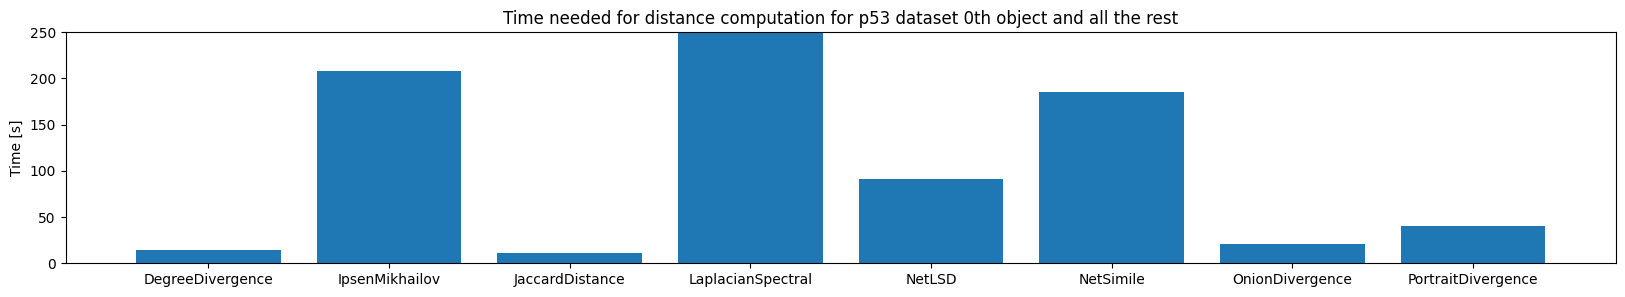

In [48]:

plt.bar(list(time_measurements.keys()), list(time_measurements.values()))
plt.title("Time needed for distance computation for p53 dataset 0th object and all the rest")
plt.ylabel("Time [s]")
plt.ylim(0,250)

[-0.07051823  0.07051823  0.01743207 ... -0.07340022 -0.04789977
  0.09027721]


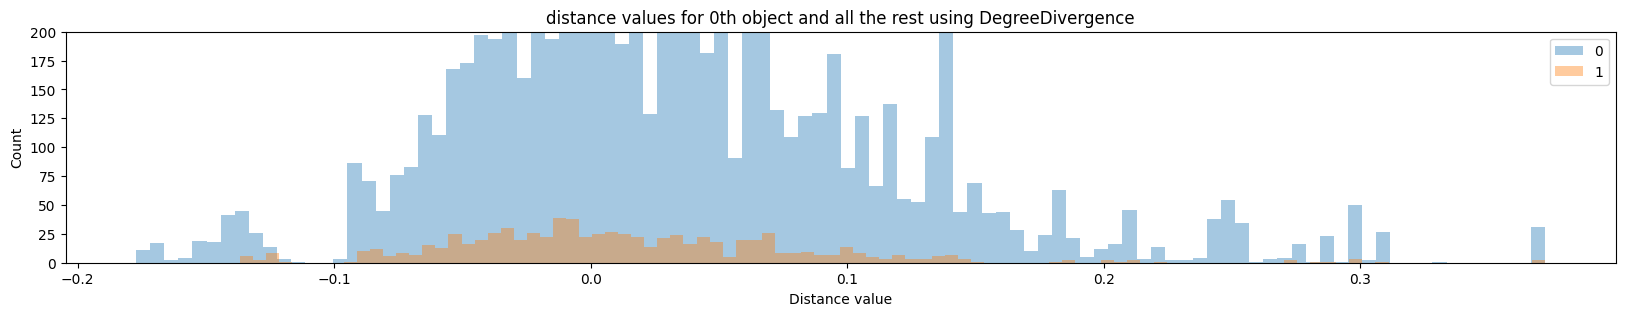

[-0.90769231  0.90769231  0.00532172 ... -0.20821221 -0.15086838
 -0.25820793]


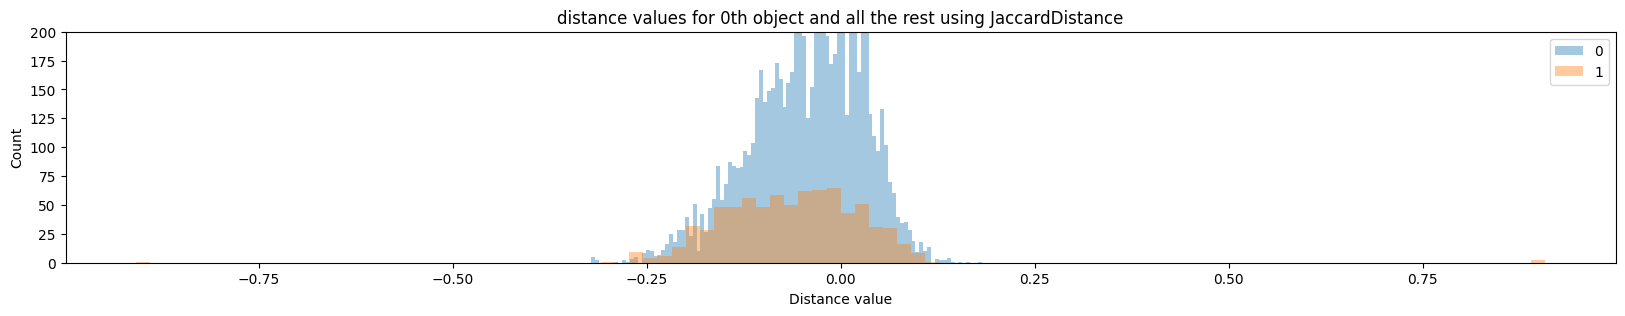

[-0.34219233  0.34219233  0.06639802 ... -0.04901644 -0.18297472
  0.05827095]


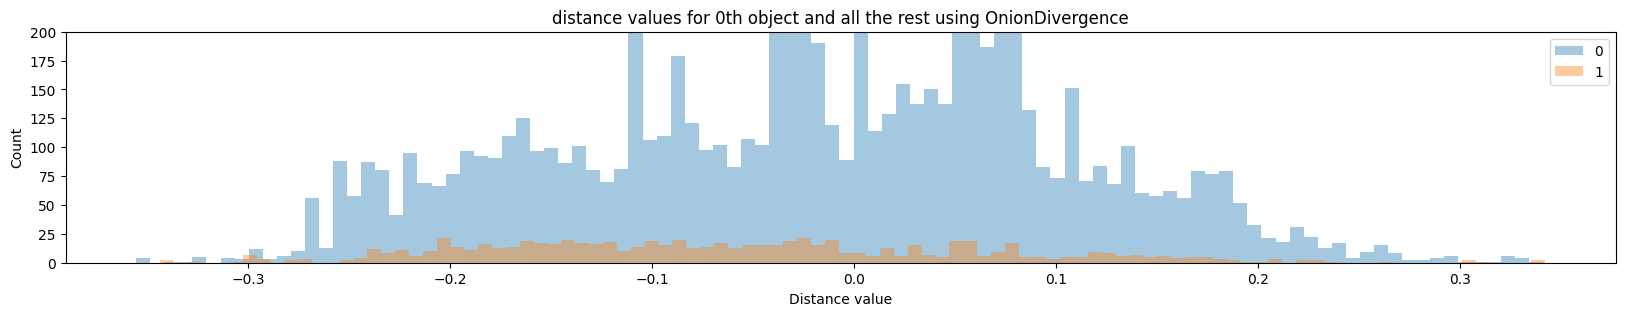

[-0.26503858  0.26503858 -0.15809809 ... -0.07983875 -0.27716135
 -0.04229896]


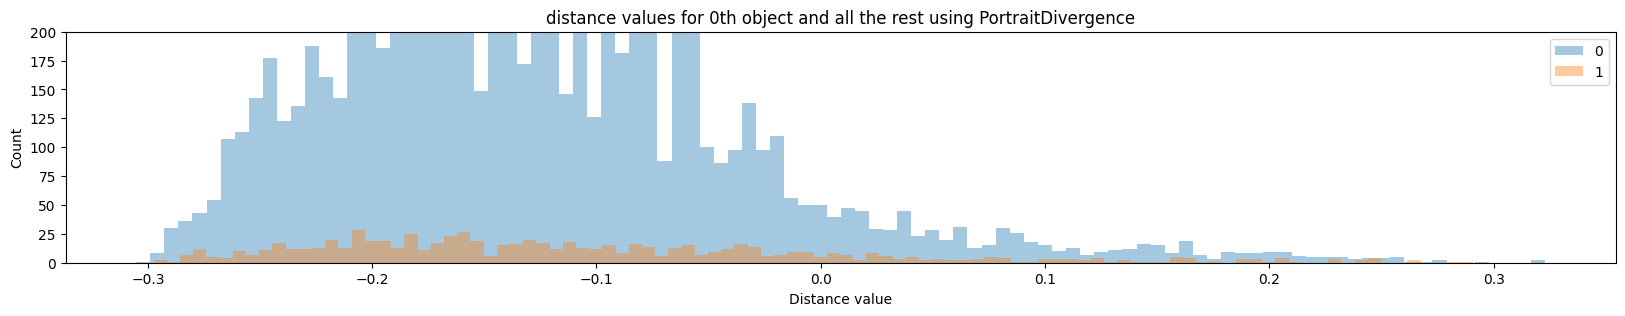

In [9]:
import pandas as pd
for f_name in time_measurements.keys():
    p_values = distance_values[0][f_name]
    q_values = distance_values[1][f_name]
    df = pd.DataFrame({"dist_sum": p_values - q_values, "y":data['y']})
    print(df.dist_sum.unique())
    df.groupby("y").dist_sum.hist(alpha=0.4, legend=True, bins=100, grid=False)
    #plt.hist(values, bins=100, label=data['y'])
    plt.title(f"distance values for 0th object and all the rest using {f_name}")
    plt.xlabel("Distance value")
    plt.ylabel("Count")
    plt.ylim(0, 200)
    plt.show()